In [ ]:
# default_exp feature_finding

# Feature Finding

> Functions related to feature finding

This part describes the implementation of the feature finding algorithm. The core of the algorithm is described in the [MaxQuant-Paper](https://www.nature.com/articles/nbt.1511).
The supplementary material explains the underlying methodology in great detail and is the foundation of the theoretical background that is described here.
A refined version of the algorithm was presented with [Dinosaur](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4933939/), which was also used as a reference for the Python implementation.

For the algorithm, we need serval modules:

1. Connecting Centroids to Hills

2. Refinement of Hills

3. Calculating Hill Statistics

4. Combining Hills to Isotope Patterns

5. Deconvolution of Isotope Patterns

Current ToDo here:

- We could validate the results against Dinosaur again.
- The result table might need adjustments
    - Should we interpolate starting / end times
    - Should we approximate the Apex of a feature?
- Proper plotting of isotope patterns / environment should reveal shortcomings of the algorithm

## Loading Data

From the `IO` library, we already have `*.ms_data.hdf` container that contains centroided data. To use it in feature finding, we load the data and convert this to a numba-compatible list of NumPy structured arrays.

In [ ]:
#export
from numba.typed import List
import numpy as np

def raw_to_centroid(query_data, callback=None):

    scans = query_data['scan_list_ms1']
    rts = query_data['rt_list_ms1']
    masses = query_data['mass_list_ms1']
    intensities = query_data['int_list_ms1']
    indices = query_data['indices_ms1']

    centroid_dtype = [("mz", float), ("int", np.int64), ("scan_no", int), ("rt", float)]
    centroids_pre = []


    for i, (s, e) in enumerate(zip(indices[:-1], indices[1:])):
        scan_no = scans[i]
        rt = rts[i]
        mass_arr = masses[s:e]
        ints_arr = intensities[s:e]

        centroids_pre.append(
            [(mz, intensity, scan_no, rt) for mz, intensity in zip(mass_arr, ints_arr)]
        )

        if callback:
            callback((i+1)/len(scans)/2)

    centroids = List()

    for i, _ in enumerate(centroids_pre):
        centroids.append(np.array(_, dtype=centroid_dtype))
        if callback:
            callback((len(scans)+i+1)/len(scans)/2)

    return centroids

## Connecting Centroids to Hills

### Connecting Centroids

In this step, we search for centroids that are connected (i.e., within a specific mass difference) over time. The connected centroids are termed hills. As we have a list of centroid lists, we ideally would have a list of tuples with indices to the centroids that describe the connected hills.

#### Pairs of Centroids
First, we define the function `get_pairs_centroids` that checks two lists of centroids and checks for pairs of centroids. As the masses in the centroid lists are sorted, we can loop through the centroids with two indices and compare the mass difference. If the mass difference is within the defined threshold, `ppm_tol` (default is 7ppm), we have found ourselves a pair. If no match is found, we can advance either index, depending on whether the mass difference is positive or negative. A pair is a `tuple` containing the index to the first centroid list `i` and the second centroid list `j` as well as the difference in ppm `delta`. We add all found pairs to a list termed `pairs`.

In [ ]:
#export
from numba import njit

@njit
def get_pairs_centroids(centroids_1, centroids_2, ppm_tol=8):
    """
    Function to compare two centroid list and extract pairs.
    """
    pairs = List()
    i, j = 0, 0
    while (i < len(centroids_1)) & (j < len(centroids_2)):
        mz1, mz2 = centroids_1[i]["mz"], centroids_2[j]["mz"]

        diff = mz1 - mz2

        mz_sum = mz1 + mz2

        delta = 2 * 1e6 * np.abs(diff) / mz_sum

        if delta < ppm_tol:
            pairs.append((i, j, delta))
            i += 1
        elif diff > 0:
            j += 1
        else:
            i += 1

    return pairs

In [ ]:
centroids_1 = np.array([(_) for _ in [300,400,500,600]], dtype=[("mz", float)])
centroids_2 = np.array([(_) for _ in [300,600,700]], dtype=[("mz", float)])

print(get_pairs_centroids(centroids_1, centroids_2))

[(0, 0, 0.0), (3, 1, 0.0)]


In [ ]:
#hide
def dummy_centroid(mz_list):
    dummy_dtype = [("mz", float)]

    centroids = np.array([(_) for _ in mz_list], dtype=dummy_dtype)
        
    return centroids
    
def test_get_pairs_centroids():    

    centroids_1 = dummy_centroid([300,400,500,600])
    centroids_2 = dummy_centroid([300,400,500,700])

    pairs = get_pairs_centroids(centroids_1, centroids_2)

    assert len(pairs) == 3 #300, 400, 500

    for pair in pairs:
        id_0, id_1, delta = pair
        assert np.abs(centroids_1[id_0]['mz'] - centroids_1[id_0]['mz']) == delta
        
test_get_pairs_centroids()

#### Connecting all Centroids

As we now have a function that can find pairs of centroids when given two lists of centroids, the next step is to write a function that connects all the centroids within a dataset. For this, we define the function `connect_centroids`. Here, we use the `get_pairs_centroids` function to connect hills in consecutive scans `(n->n+1)` whenever their centroid m/z positions differ less than the defined threshold. If no matching peak is found in the next scan `(n+1)`, additional scans can be considered when looking in the scan after next `(n+2)`. The maximum distance between two hills can be set via the `gap` parameter. 

For an efficient implementation to find all connected hills over all scans, we create a sparse matrix, named `results` that represent indices to all possible centroids. As the number of centroids varies for each scan, not all positions within the matrix represent a valid centroid. To distinguish these values, we fill the matrix with `-1` upon initialization. We can use the matrix to store the matching centroid as an integer that encodes its position. The x,y index for each cell represents the indices to the centroid list. The idea here is to have an efficient data structure to represent connections between centroids.

To calculate indexes back and forth we define the functions `tup_to_ind` and `ind_to_tup`. This could in principle be also done with `numpy.unravel_index`, however, the numba implementation seems to be much faster.

Additionally, we define a sparse matrix named `scores` that is intended to store the mass difference. If there are multiple possible connections between two centroids, only the best (i.e., shortest distance) will be stored.

The idea behind the matrix-indexing is explained with the following example:

##### Example: 

Imagine you have three scans with the following centroids:

* Scan 0: 10, 20, 30
* Scan 1: 10.2, 40.1
* Scan 2: 40, 50, 60


When comparing consecutive scans and defining the maximum delta mass to be 0.5 find the following connections: (Scan No, Centroid No) -> (Scan No, Centroid No). As we cannot easily store tuples in the matrix, we convert tuple containing the position of the connected centroid to an integer.
* (0,0) -> (1,0) -> (3): 10 & 10.2 -> delta = 0.2
* (1,1) -> (2,0) -> (6): 40.1 & 40 -> delta = 0.1

Finally, we store this in the `results` matrix:

$\begin{bmatrix}
3 & -1  & -1 \\ 
-1 & 6 & -1\\ 
-1 & -1 & -1 
\end{bmatrix}$

The coressponding `scores` matrix will look as follows:

$\begin{bmatrix}
0.2 & -1  & -1 \\ 
-1 & 0.1 & -1\\ 
-1 & -1 & -1 
\end{bmatrix}$

This allows us to not only easily store connections between centroids but also perform a quick lookup for the delta of an existing connection. Note that it also only stores the best connection for each centroid. To extract the connected centroids, we can use `np.where(results >= 0)`. This implementation allows getting millions of connections within seconds. 

##### Foward and Backward Search

One thing that still needs to be considered is that when searching with a large mass tolerance, we could get multiple matches that we do not want. Consider the following example:

* Scan 0: 10 (a), 
* Scan 1: 10 (b) , 10.1 (c)
* Scan 2: 10 (d)

As we only allow one connection per mass, we would have the following connections:

* a -> b
* b -> d

Now if we have a large delta mass, e.g. of `0.1`, there would be an additional connection:

* c-> d


![undirected](images/undirected.png)

The resulting hill would have a branch to the c centroid, which is obviously intended. To circumvent this, we additionally perform the search backwards. (Note the functions `connect_centroids_forward` and `connect_centroids_backward`).  Now, as we only store, the best connection between two centroids  `d` will only be connected to `b`. To, therefore, remove branches, we remove all connections that are not double.


![directed](images/directed.png)

We define a wrapper function named `connect_centroids` that allows to search with a gaps ize and returns lists of indices of the connected centroids.

In [ ]:
#export
from numba import int32, float32

@njit
def tup_to_ind(tup, r_shape):
    """
    Convert tuple to index
    """
    ind = r_shape[1] * tup[0] + tup[1]
    return ind

@njit
def ind_to_tup(ind, r_shape):
    """
    Convert index to tuple
    """
    row = ind // r_shape[1]
    col = ind - row * r_shape[1]
    return (row, col)

@njit
def connect_centroids_(centroids, max_centroids, max_gap, ppm_tol, direction):
    """
    Function to connect lists of centroids - forward direction
    """

    connections = (
        np.zeros(
            (len(centroids), max_centroids, max_gap+1), dtype=int32
        )
        - 1
    )

    scores = (
        np.zeros(
            (len(centroids), max_centroids, max_gap+1), dtype=float32
        )
        + np.inf
    )


    c_shape = connections.shape

    for gap in range(max_gap+1):
        j = 1 + gap

        for i in range(len(centroids) - gap - 1):
            if direction == 'forward':
                centroids_1 = centroids[i]
                centroids_2 = centroids[i + j]
            else:
                centroids_1 = centroids[i + j]
                centroids_2 = centroids[i]

            for pair in get_pairs_centroids(centroids_1, centroids_2, ppm_tol):
                if direction == 'forward':
                    ii = pair[0]
                    jj = pair[1]
                else:
                    jj = pair[0]
                    ii = pair[1]
                    
                delta = pair[2]
                index = tup_to_ind((i + j, jj), c_shape)

                if scores[i, ii, gap] > delta:
                    connections[i, ii, gap] = index
                    scores[i, ii, gap] = delta

    return connections, scores


def connect_centroids(centroids, max_gap = 2 , ppm_tol = 8):
    """
    Wrapper function to connect lists of centroids via foward and backward search
    """
    max_centroids = np.max([len(_) for _ in centroids])

    connections_f, scores_f = connect_centroids_(centroids, max_centroids, max_gap, ppm_tol, 'forward')
    connections_b, scores_b = connect_centroids_(centroids, max_centroids, max_gap, ppm_tol, 'backward')

    connections = (
        np.zeros(
            (len(centroids), max_centroids, max_gap+1), dtype=np.int
        )
        - 1
    )

    connections[connections_f == connections_b] = connections_f[connections_f == connections_b]

    c_shape = connections.shape

    from_r, from_c, from_g = np.where(connections >= 0)
    to_r, to_c = ind_to_tup(connections[from_r, from_c, from_g], c_shape)

    return from_r, from_c, to_r, to_c

In [ ]:
centroids_1 = np.array([(_) for _ in [300,400,500,600,800]], dtype=[("mz", float)])
centroids_2 = np.array([(_) for _ in [300,400,500,700,900]], dtype=[("mz", float)])
centroids_3 = np.array([(_) for _ in [300,400,500,600,1000]], dtype=[("mz", float)])

centroid_list = List([centroids_1, centroids_2, centroids_3])

connect_centroids(centroid_list)

(array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=int64),
 array([0, 0, 1, 1, 2, 2, 3, 0, 1, 2], dtype=int64),
 array([1, 2, 1, 2, 1, 2, 2, 2, 2, 2], dtype=int64),
 array([0, 0, 1, 1, 2, 2, 3, 0, 1, 2], dtype=int64))

In [ ]:
#hide
def test_tup_to_ind():
    r_shape = (25,25)
    tup = (9,5)
    ind = tup_to_ind(tup, r_shape)
    assert ind_to_tup(ind, r_shape) == tup
    assert np.unravel_index(ind, r_shape) == tup

test_tup_to_ind()

def test_connect_centroids():
    centroids_1 = dummy_centroid([300,400,500,600,800])
    centroids_2 = dummy_centroid([300,400,500,700,900])
    centroids_3 = dummy_centroid([300,400,500,600,1000])

    centroid_list = List([centroids_1, centroids_2, centroids_3])

    from_r, from_c, to_r, to_c = connect_centroids(centroid_list)

    assert len(from_r) == 10 # 3x300, 3x400,3x500, 1x600

test_connect_centroids()

### Connecting hills

Having all the connected centroids, we would like to find `hills`, referring to centroids that are connected. We can achieve this by creating a graph `G` with the `networkx`-package. Here, each connection is added as an edge using the `add_edge` method to the graph. We can then use the `connected_components` function to extract all the connected components.

`NetworkX` is known to be memory [consuming](https://groups.google.com/forum/#!topic/networkx-discuss/Etd4GpkjPdA) and can take hundreds of bytes per edge. For millions of connections, we will, therefore, consume Gigabytes of memory. To keep the graph small, we continuously feed the graph until we reach a certain scan number `buffer size`. Once the limit is reached, we extract all completed hills and remove all nodes that are part of a completed hill or cannot be connected anymore. Once all edges are added, we perform a final extraction step. Finally, everything is put into the `get_hills` function.

#### Parallelization Strategies

Currently, the parallel connection of hills is not implemented yet. A possible way could be to process individual chunks of edges in parallel and then combine them together, as it is done in `Dinosaur`.

In [ ]:
#export
import networkx as nx
from collections import Counter

def get_hills(centroids, max_gap = 2, min_hill_length = 3, ppm_tol = 8, buffer_size = 2000, callback=None):

    """
    Function to get hills from connected centroids

    """

    from_r, from_c, to_r, to_c = connect_centroids(centroids, max_gap, ppm_tol)

    completed_hills = []
    current_scan = 0

    idx = 0

    G = nx.Graph()

    for current_scan in range(0, len(centroids)):
        #Feed edges until next scan
        while from_r[idx] == current_scan:
            G.add_edge((from_r[idx], from_c[idx]), (to_r[idx], to_c[idx]))
            if idx < len(from_r)-1:
                idx+=1
            else:
                break


        if current_scan % buffer_size == 0:
            # Get all connected components:
            c_comps = list(nx.connected_components(G))

            for hill in c_comps:
                if len(hill) >= min_hill_length:
                    hill = list(hill)
                    hill.sort()
                    max_scan = hill[-1][0]

                    if max_scan < current_scan - max_gap: #can't be more
                        completed_hills.append(hill)

                        for node in hill:
                            G.remove_node(node)

        if callback:
            callback((current_scan+1)/len(centroids))


    c_comps = list(nx.connected_components(G))
    for hill in c_comps:
        if len(hill) >= min_hill_length:
            hill = list(hill)
            hill.sort()
            completed_hills.append(hill)

    return completed_hills

In [ ]:
centroids_1 = np.array([(_) for _ in [300,400,500,600,800]], dtype=[("mz", float)])
centroids_2 = np.array([(_) for _ in [300,400,500,700,900]], dtype=[("mz", float)])
centroids_3 = np.array([(_) for _ in [300,400,500,600,1000]], dtype=[("mz", float)])

centroid_list = List([centroids_1, centroids_2, centroids_3])

get_hills(centroid_list)

[[(0, 0), (1, 0), (2, 0)], [(0, 1), (1, 1), (2, 1)], [(0, 2), (1, 2), (2, 2)]]

In [ ]:
#hide
def test_get_hills():
    centroids_1 = np.array([(_) for _ in [300,400,500,600,800]], dtype=[("mz", float)])
    centroids_2 = np.array([(_) for _ in [300,400,500,700,900]], dtype=[("mz", float)])
    centroids_3 = np.array([(_) for _ in [300,400,500,600,1000]], dtype=[("mz", float)])

    centroid_list = List([centroids_1, centroids_2, centroids_3])

    hills = get_hills(centroid_list)
    
    assert len(hills) == 3
    
    assert [(0, 0), (1, 0), (2, 0)] in hills
    assert [(0, 1), (1, 1), (2, 1)] in hills
    assert [(0, 2), (1, 2), (2, 2)] in hills
    
test_get_hills()

In [ ]:
#export
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_hill(hill, centroids):

    """
    Helper function to plot the hill
    """
    centroid_dtype = [("mz", float), ("int", np.int64), ("scan_no", int), ("rt", float)]
    hill_data = np.array([centroids[_[0]][_[1]] for _ in hill], dtype=centroid_dtype)

    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))
    ax1.plot(hill_data["rt"], hill_data["int"])
    ax1.set_title('Hill')
    ax1.set_xlabel('RT (min)')
    ax1.set_ylabel('Intensity')

    ax2.plot(hill_data["rt"], hill_data["mz"])
    ax2.set_xlabel('RT (min)')
    ax2.set_ylabel('m/z')

## Refinement of Hills

There are several methods implemented to refine the hills.

### Smoothing of Hills

For smoothing, we use the function `smooth` that first uses a median smoothing (`smooth_median`) which is followed by a mean smoothing (`smooth_mean`) over a defined `window` size.

In [ ]:
#export
@njit
def smooth_mean(y, window):
    "Mean smoothing"
    y_new = np.zeros(len(y))
    for i in range(len(y)):
        min_index = np.max(np.array([0, i - window]))
        max_index = np.min(np.array([len(y), i + window + 1]))
        y_new[i] = np.mean(y[min_index:max_index])

    return y_new

@njit
def smooth_median(y, window):
    "Median smoothing"
    y_new = np.zeros(len(y))
    for i in range(len(y)):
        min_index = np.max(np.array([0, i - window]))
        max_index = np.min(np.array([len(y), i + window + 1]))
        y_new[i] = np.median(y[min_index:max_index])

    return y_new

@njit
def smooth(y, window):
    "First median smoothing, then mean smoothing"

    y = smooth_median(y, window)
    y = smooth_mean(y, window)

    return y

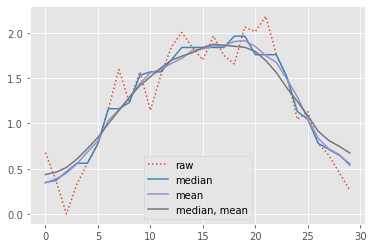

In [ ]:
sample_signal = np.array([0.67738253, 0.36984442, 0.        , 0.32625508, 0.56053166,
       0.77507687, 1.1627611 , 1.59562655, 1.23306671, 1.5700985 ,
       1.14596591, 1.53259171, 1.84393649, 2.0070499 , 1.84017847,
       1.70272915, 1.96492529, 1.75232992, 1.65872689, 2.06630325,
       2.01519359, 2.18511221, 1.7601257 , 1.51759074, 1.0450398 ,
       1.13274011, 0.77871398, 0.64859666, 0.45549976, 0.26360763])

window = 3

plt.plot(sample_signal, label='raw', linestyle =':')
plt.plot(smooth_median(sample_signal, window), label='median')
plt.plot(smooth_mean(sample_signal, window), label='mean')

plt.plot(smooth(sample_signal, window), label='median, mean')

plt.legend()
plt.show()

### Hill Splitting
When having a hill with two or more maxima, we would like to split it at the minimum position. For this, we use a recursive approach. First, the minimum of a hill is detected. A hill is split at this minimum if the smaller of the surrounding maxima is at least the factor `split_level` larger than the minimum. For each split, the process is repeated.

In [ ]:
#export
@njit
def get_minima(y):
    """
    Function extract the mimnima of a trace.
    Here, the definition of a minimum is:
    (1) left and right value are larger
    (2) second right and left are larger, right is equal
    (3) second left and right are larger, left is equal

    """
    minima = []
    for i in range(2, len(y) - 2):
        if (y[i - 1] > y[i]) & (y[i + 1] > y[i]):
            minima.append(i)
        elif (y[i - 1] > y[i]) & (y[i + 1] == y[i]) & (y[i + 2] > y[i]):
            minima.append(i)
        elif (y[i - 2] > y[i]) & (y[i - 1] == y[i]) & (y[i + 1] > y[i]):
            minima.append(i)
        elif (
            (y[i - 2] > y[i])
            & (y[i - 1] == y[i])
            & (y[i + 1] == y[i])
            & (y[i + 2] > y[i])
        ):
            minima.append(i)
    return minima

[8, 20]


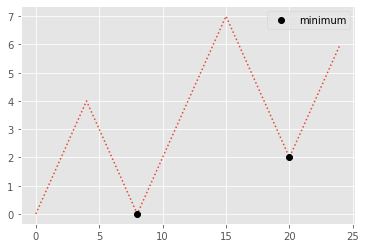

In [ ]:
trace = np.array([0,1,2,3,4,3,2,1,0,1,2,3,4,5,6,7,6,5,4,3,2,3,4,5,6])

minima = get_minima(trace)

print(minima)

plt.plot(trace,':')
plt.plot(minima, trace[minima], 'ko', label='minimum')
plt.legend()
plt.show()

In [ ]:
#hide
def test_get_minima():
    test_sequence = np.array([10, 10, 5, 10, 10, 5, 5, 10, 10, 5, 5, 5, 10])
    assert np.all(
        np.array(get_minima(test_sequence)) == np.array([2, 5, 6, 10])
    )  # 5 is seen as minima twice
    
test_get_minima()

In [ ]:
#export
def split_hills(hills, centroids, smoothing = 1, split_level=5, callback=None):
    """
    Wrapper to split list of hills
    """
    centroid_dtype = [("mz", float), ("int", np.int64), ("scan_no", int), ("rt", float)]
    split_hills = []
    for index, current_hill in enumerate(hills):
        hill_data = np.array([centroids[_[0]][_[1]] for _ in current_hill], dtype=centroid_dtype)

        split_hills.extend(split_hill(hill_data, current_hill, smoothing, split_level))

        if callback:
            callback((index+1)/len(hills))

    split_hills.sort(key=len, reverse=True)

    return split_hills

def split_hill(hill_data, current_hill, smoothing, split_level):
    """
    Wrapper to call recursive function to split hill
    """
    y = hill_data["int"]
    y_smooth = smooth(y, smoothing)

    splits = split_recursive(current_hill, y_smooth, split_level)

    return splits



def split_recursive(current_hill, y_smooth, split_level):
    """
    Recursive function to split hill
    """

    splits = []

    minima = np.array(get_minima(y_smooth), dtype=np.int64)
    sorted_minima = minima[np.argsort(y_smooth[minima])]

    for minpos in sorted_minima:  # Loop through minima, start with lowest value

        minval = y_smooth[minpos]

        left_side = y_smooth[:minpos]
        right_side = y_smooth[minpos:]

        left_hill = current_hill[:minpos]
        right_hill = current_hill[minpos:]

        left_max = np.max(left_side)
        right_max = np.max(right_side)

        minimum_max = np.min(np.array((left_max, right_max)))

        if minval == 0:
            minval = np.finfo(float).eps
        if minimum_max / minval > split_level:
            splits_left = split_recursive(left_hill, left_side, split_level)
            splits_right = split_recursive(right_hill, right_side, split_level)

            splits.extend(splits_left)
            splits.extend(splits_right)

            return splits

    return [current_hill]

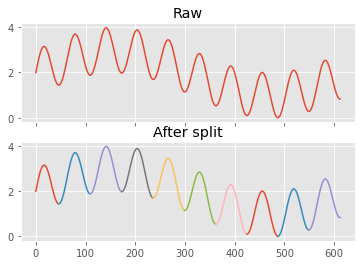

In [ ]:
#Test signal with 10 peaks
n_peaks = 10
x = np.arange(0, n_peaks*np.pi*2-np.pi/2,0.1)
yy = np.sin(x/n_peaks) + np.sin(x)

y_smooth = yy- np.min(yy)

current_hill = np.arange(len(y_smooth))

splits = split_recursive(current_hill, y_smooth, split_level=5)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(y_smooth)
ax1.set_title('Raw')
for split in splits:
    ax2.plot(split, y_smooth[split])
ax2.set_title('After split')
plt.show()

In [ ]:
#hide
def test_split_recursive():

    y_smooth = np.array([1,2,3,4,5,6,7,8,9,10,9,8,7,6,5,4,3,2,1,
             1,2,3,4,5,6,7,8,9,10,9,8,7,6,5,4,3,2,1,
             1,2,3,4,5,6,7,8,9,10,9,8,7,6,5,
             5,6,7,8,9,10,9,8,7,6,5,4,3,2,2,
            1,2,3,4,5,6,7,8,9,10,9,8,7,6,5,4,3,2,1,
                        1,2,3,4,5,6,7,8,9,10,9,8,7,6,5,4,3,2,1])

    current_hill = np.arange(len(y_smooth))

    split = 5

    splits = split_recursive(current_hill, y_smooth, split)

    assert len(splits) == 6
    assert len(y_smooth) == np.sum([len(_) for _ in splits])

    # Generate dummy signal
    n_peaks = 10
    x = np.arange(0,n_peaks*np.pi*2-np.pi/2,0.1)   # start,stop,step
    yy = np.sin(x/n_peaks)
    y = np.sin(x)

    yyy = y+yy
    yyy -= np.min(yyy)


    y_smooth = yyy

    current_hill = np.arange(len(y_smooth))

    split = 5

    splits = split_recursive(current_hill, y_smooth, split)

    assert len(splits) == n_peaks
    assert len(y_smooth) == np.sum([len(_) for _ in splits])
        
# test_split_recursive()

### Filter Hills

To filter hills, we define a minimum length `hill_min_length`. All peaks below the threshold `hill_peak_min_length` are accepted as is. For longer hills, the intensity at the start and the end are compared to the maximum intensity. If the ratio of the maximum raw intensity to the smoothed intensity and the beginning and end are larger than `hill_peak_factor` the hills are accepted.

In [ ]:
#export
def filter_hills(hills, centroids, hill_min_length=2, hill_peak_factor=2, hill_peak_min_length=40, smoothing=1, callback=None):
    """
    Wrapper function to perform filtering on lists of hills
    """
    centroid_dtype = [("mz", float), ("int", np.int64), ("scan_no", int), ("rt", float)]
    filtered_hills = []
    for idx, current_hill in enumerate(hills):
        if len(current_hill) > hill_min_length:
            if len(current_hill) < hill_peak_min_length:
                filtered_hills.append(current_hill)
            else:
                hill_data = np.array([centroids[_[0]][_[1]] for _ in current_hill], dtype=centroid_dtype)
                int_profile = hill_data["int"]
                maximum = np.max(int_profile)
                y_smooth = smooth(int_profile, smoothing)

                if (maximum / y_smooth[0] > hill_peak_factor) & (maximum / y_smooth[-1] > hill_peak_factor):
                    filtered_hills.append(current_hill)

        if callback:
            callback((idx+1) / len(hills))

    return filtered_hills

Since the mass estimate min the equation above is more complicated than just an average of the mj, a standard deviation based estimate of the error would not be appropriate. Therefore we calculate the error as a bootstrap2 estimate over B=150 bootstrap replications


## Calculating Hill Statistics

Next, we calculate summary statistics for the connected centroids. We can obtain a high precision mass estimate for each hill by taking the average of the the masses and weighting this by their intensiteis:

$$
\overline{m} = \frac{\sum_{j=1}^nm_jI_j}{\sum_{j=1}^nI_j}
$$

To estimate the mass error, we calculate the error as a boostrap estimate:
 
$$\Delta \overline{m} = \sqrt{\frac{\sum_{b=1}^{B}(\overline{m}_b - \overline{m} )}{(B-1)}}$$

The calculation of hill statistics for a single hill is implemented in `get_hill_stats`. To calculate the hill stats for a list of hills, we can call the wrapper `get_hill_data`.

In [ ]:
#export
@njit
def weighted_average(array, weights):
    """
    Calculate the weighted average of an array
    """
    return np.sum((array * weights)) / np.sum(weights)

In [ ]:
#hide
def test_weighted_average():    
    array = np.array([82, 90, 76])
    weights = np.array([20, 35, 45])

    assert np.allclose(weighted_average(array, weights), 82.1)

In [ ]:
#export

@njit
def get_hill_stats(hill_data, hill_nboot = 300, hill_nboot_max = 300):

    """
    Calculate hill statistics with bootstraping and weighted averages
    """
    
    np.random.seed(42) #Reset the random number generator
    
    min_rt, max_rt = hill_data["rt"].min(), hill_data["rt"].max()
    summed_intensity = hill_data["int"].sum()
    apex_intensity = hill_data["int"].max()

    if len(hill_data) > hill_nboot_max:
        bootsize = hill_nboot_max
    else:
        bootsize = len(hill_data)

    averages = np.zeros(hill_nboot)

    average = 0

    for i in range(hill_nboot):
        boot = hill_data[np.random.choice(len(hill_data), bootsize, replace=True)]
        boot_mz = weighted_average(boot["mz"], boot["int"])
        averages[i] = boot_mz
        average += boot_mz

    average_mz = average/hill_nboot

    delta = 0
    for i in range(hill_nboot):
        delta += (average_mz - averages[i]) ** 2 #maybe easier?

    delta_m = np.sqrt(delta / (hill_nboot - 1))

    return average_mz, delta_m, min_rt, max_rt, summed_intensity, apex_intensity


@njit
def get_hill_data_numba(hill_data):
    hill_stats = np.zeros((len(hill_data), 6))
    for i in range(len(hill_data)):
        average_mz, delta_m, min_rt, max_rt, summed_intensity, apex_intensity = get_hill_stats(hill_data[i])
        hill_stats[i, 0] = average_mz
        hill_stats[i, 1] = delta_m
        hill_stats[i, 2] = min_rt
        hill_stats[i, 3] = max_rt
        hill_stats[i, 4] = summed_intensity
        hill_stats[i, 5] = apex_intensity

    return hill_stats


def get_hill_data(hills, centroids, callback=None):
    """
    Function to calculate hill statistics from hills
    """

    centroid_dtype = [("mz", float), ("int", np.int64), ("scan_no", int), ("rt", float)]

    hill_data = List()

    for idx, hill in enumerate(hills):
        hill_data.append(np.array([centroids[_[0]][_[1]] for _ in hill], dtype=centroid_dtype))

        if callback:
            callback((idx+1)/len(hills)*0.5) #First half


    hill_stats = get_hill_data_numba(hill_data)

    stats_dtype = [
            ("mz_avg", float),
            ("delta_m", float),
            ("rt_min", float),
            ("rt_max", float),
            ("int_sum", np.int64),
            ("int_max", np.int64),
        ]

    sortindex = np.argsort(hill_stats[:, 2])
    sorted_stats = hill_stats[sortindex]
    sorted_hills = np.array(hills, dtype='object')[sortindex]
    sorted_data = np.array(hill_data, dtype='object')[sortindex]

    sorted_stats = np.core.records.fromarrays(sorted_stats.T, dtype=stats_dtype)

    sorted_data_numba = List()

    for idx, _ in enumerate(sorted_data):
        sorted_data_numba.append(_)

        if callback:
            callback((idx+1)/len(sorted_data)+0.5) #Second half

    return sorted_hills, sorted_stats, sorted_data_numba

In [ ]:
test_centroids = [
    [(600, 1, 1, 1)],
    [(300, 1, 2, 2), (600, 0, 1, 2)],
    [(300, 10, 3, 3), (600, 20, 3, 3)],
    [(300, 20, 4, 4), (600, 40, 4, 4)],
    [(300, 40, 5, 5), (600, 80, 5, 5)],
    [(300, 20, 6, 6), (600, 40, 6, 6)],
    [(300, 10, 7, 7), (600, 20, 7, 7)],
    [(300, 1, 8, 8), (600, 0, 8, 8)],
]

centroid_dtype = [("mz", float), ("int", np.int64), ("scan_no", int), ("rt", float)]
test_centroids_tmp = [np.array(_, dtype=centroid_dtype) for _ in test_centroids]

test_centroids = List([_ for _ in test_centroids_tmp])

test_hills = get_hills(test_centroids)
sorted_hills, sorted_stats, sorted_data_numba = get_hill_data(test_hills, test_centroids)

print('Hill Statistics')
print(sorted_stats)

Hill Statistics
[(600., 0., 1., 8., 201, 80) (300., 0., 2., 8., 102, 40)]


In [ ]:
#hide
def test_get_hill_data():
    test_centroids = [
        [(600, 1, 1, 1)],
        [(300, 1, 2, 2), (600, 0, 1, 2)],
        [(300, 10, 3, 3), (600, 20, 3, 3)],
        [(300, 20, 4, 4), (600, 40, 4, 4)],
        [(300, 40, 5, 5), (600, 80, 5, 5)],
        [(300, 20, 6, 6), (600, 40, 6, 6)],
        [(300, 10, 7, 7), (600, 20, 7, 7)],
        [(300, 1, 8, 8), (600, 0, 8, 8)],
    ]

    centroid_dtype = [("mz", float), ("int", np.int64), ("scan_no", int), ("rt", float)]
    test_centroids_tmp = [np.array(_, dtype=centroid_dtype) for _ in test_centroids]

    test_centroids = List([_ for _ in test_centroids_tmp])

    test_hills = get_hills(test_centroids)
    sorted_hills, sorted_stats, sorted_data = get_hill_data(test_hills, test_centroids)

    # Check masses
    assert sorted_stats[0]["mz_avg"] == 600
    assert sorted_stats[1]["mz_avg"] == 300

    # Check intensities
    assert sorted_stats[0]["int_sum"] == 201
    assert sorted_stats[1]["int_sum"] == 102

    # Check start
    assert sorted_stats[0]["rt_min"] == 1
    assert sorted_stats[1]["rt_min"] == 2
    
test_get_hill_data()

## Combining Hills to Isotope Patterns

After obtaining summary statistics of hills, the next step is to check whether they belong together to form an isotope pattern. For this, we check wheter it is possible that they are neighbors in an isotope pattern, e.g. one having a 12C atom that has been replaced by a 13C version. The detailed criterion for the check is implemented in `check_isotope_pattern` and is as follows:


$$\left | \Delta m-\frac{\Delta M}{z} \right |\leq \sqrt{\left ( \frac{\Delta S}{z}  \right )^{2}+\Delta {m_{1}}^{2} +\Delta {m_{2}}^{2}}$$

The left side contains $\Delta m$, being the delta of the precise mass estimates from the summary statistics and $\Delta M = 1.00286864$, which is the mass difference ebtween the 13C peak and the monoisotopic peak in an averagine molecule of 1500 Da mass divided by the charge $z$.

The right side contains $\Delta S = 0.0109135$, which is the maximum shift that a sulphur atom can cause ($\Delta S = 2m(^{13}C) - 2m(^{12}C) - m(^{34}S) + m(^{32}S)$) and $\Delta {m_{1}}$ and $\Delta {m_{2}}$, which are the bootstrapped mass standard deviations.

In [ ]:
#export
from alphapept.constants import mass_dict
from numba import njit

DELTA_M = mass_dict['delta_M']
DELTA_S = mass_dict['delta_S']

@njit
def check_isotope_pattern(mass1, mass2, delta_mass1, delta_mass2, charge, mass_range = 5):
    """
    Check if two masses could belong to the same isotope pattern
    """
    delta_mass1 = delta_mass1 * mass_range
    delta_mass2 = delta_mass2 * mass_range

    delta_mass = np.abs(mass1 - mass2)

    left_side = np.abs(delta_mass - DELTA_M / charge)
    right_side = np.sqrt((DELTA_S / charge) ** 2 + delta_mass1 ** 2 + delta_mass2 ** 2)

    return left_side <= right_side

In [ ]:
charge = 1

mass1, delta_mass1 = 100, 0.1
mass2, delta_mass2 = 101.1, 0.05

print(check_isotope_pattern(mass1, mass2, delta_mass1, delta_mass2, charge))

mass2, delta_mass2 = 102.1, 0.05

print(check_isotope_pattern(mass1, mass2, delta_mass1, delta_mass2, charge))

True
False


### Cosine Correlation of two hills

An additional criterion that is being checked is that the intensity profiles have sufficient overalp in retention time. This is validated by ensuring that two hills have a cosine correlation of at least 0.6.

$$\frac{\sum_{s=s_{min}}^{s_{max}}I_sJ_s}{\sum_{s=s_{min}}^{s_{max}}I_s^{2} \sum_{s=s_{min}}^{s_{max}}J_s^{2}} \geq 0.6$$

The intensities of two hills are only compared if both have an intensity value in a particular scan. Otherwise, the intensity is set to zero. Additionally, an overlap of at least three elements is required. 

In [ ]:
#export 
@njit
def cosinec(hill_data_one, hill_data_two):
    """
    Cosine Correlation of two hills
    """
    int_one = hill_data_one["int"]
    spec_one = hill_data_one["scan_no"]

    int_two = hill_data_two["int"]
    spec_two = hill_data_two["scan_no"]

    min_one, max_one = spec_one[0], spec_one[-1]
    min_two, max_two = spec_two[0], spec_two[-1]

    if min_one + 3 > max_two:  # at least an overlap of 3 elements
        corr = 0
    elif min_two + 3 > max_one:
        corr = 0
    else:
        min_s = np.min(np.array([min_one, min_two]))
        max_s = np.max(np.array([max_one, max_two]))

        int_one_scaled = np.zeros(int(max_s - min_s + 1))
        int_two_scaled = np.zeros(int(max_s - min_s + 1))

        int_one_scaled[spec_one - min_s] = int_one
        int_two_scaled[spec_two - min_s] = int_two

        corr = np.sum(int_one_scaled * int_two_scaled) / np.sqrt(
            np.sum(int_one_scaled ** 2) * np.sum(int_two_scaled ** 2)
        )

    return corr

In [ ]:
#hide

def test_cosinec():
    centroid_dtype = [
        ("mz", float),
        ("int", np.int64),
        ("start", int),
        ("center", int),
        ("end", int),
        ("scan_no", int),
        ("rt", float),
    ]

    hill_data_one = np.array(
        [
            (300, 100, 0, 1, 2, 0, 0),
            (300, 200, 0, 1, 2, 1, 0),
            (300, 300, 0, 1, 2, 2, 0),
            (300, 400, 0, 1, 2, 3, 0),
            (300, 500, 0, 1, 2, 6, 0),
        ],
        dtype=centroid_dtype,
    )

    assert cosinec(hill_data_one, hill_data_one) == 1

    hill_data_two = np.array(
        [
            (300, 500, 0, 1, 2, 7, 0),
            (300, 400, 0, 1, 2, 8, 0),
            (300, 300, 0, 1, 2, 9, 0),
            (300, 200, 0, 1, 2, 10, 0),
            (300, 100, 0, 1, 2, 11, 0),
        ],
        dtype=centroid_dtype,
    )

    assert cosinec(hill_data_one, hill_data_two) == 0

    hill_data_two = np.array([(300, 500, 0, 1, 2, 6, 0)], dtype=centroid_dtype)

    assert cosinec(hill_data_one, hill_data_two) == 0
    
test_cosinec()

### Extracting pre-Isotope Patterns

Now having two criteria to check whether hills could, in principle, belong together, we define the wrapper functions `extract_edge` and `get_edges` to extract the connected hills. To minimize the number of comparisons we need to perform, we only compare the hills that overlap in time (i.e., the start of one hill `rt_min` needs to be before the end of the other hill `rt_max`) and are less than the sum of $\Delta M$ and $\Delta S$ apart. 

To extract all hills that belong together, we again rely on the `NetworkX`-package to extract the connected components. 

In [ ]:
#export
@njit
def extract_edge(sorted_stats, runner, maxindex, min_charge = 1, max_charge = 6, mass_range=5):
    """
    Extract edge
    """

    maximum_offset = DELTA_M + DELTA_S

    edges = []

    mass1, delta_mass1, rt_min, rt_max = (
        sorted_stats[runner]["mz_avg"],
        sorted_stats[runner]["delta_m"],
        sorted_stats[runner]["rt_min"],
        sorted_stats[runner]["rt_max"],
    )

    delta = 1

    for index in range(runner + 1, maxindex):

        mass2, delta_mass2, rt_min = (
            sorted_stats[index]["mz_avg"],
            sorted_stats[index]["delta_m"],
            sorted_stats[index]["rt_min"],
        )

        if np.abs(mass2 - mass1) <= maximum_offset:
            for charge in range(min_charge, max_charge + 1):
                if check_isotope_pattern(mass1, mass2, delta_mass1, delta_mass2, charge, mass_range):
                    edges.append((runner, index))
                    break

    return edges

import networkx as nx

def get_edges(sorted_stats, hill_datas, cc_cutoff = 0.6, min_charge=1, max_charge=6, mass_range=5, callback=None, **kwargs):
    """
    Wrapper function to extract pre isotope patterns
    """

    pre_isotope_patterns = []

    idxs_upper = sorted_stats["rt_min"].searchsorted(
        sorted_stats["rt_max"], side="right"
    )

    pre_edges = []
    delta = []

    # Step 1
    for runner in range(len(sorted_stats)):
        pre_edges.extend(extract_edge(sorted_stats, runner, idxs_upper[runner], min_charge, max_charge, mass_range))

        if callback:
            callback((runner+1)/len(sorted_stats)*1/2)

    # Step 2
    edges = []
    for runner in range(len(pre_edges)):
        edge = pre_edges[runner]

        x = edge[0]
        y = edge[1]

        if cosinec(hill_datas[x], hill_datas[y]) > cc_cutoff:
            edges.append(edge)

        if callback:
            callback((runner+1)/len(pre_edges)*1/2+1/2)


    # Step 3
    G2 = nx.Graph()
    for edge in edges:
        G2.add_edge(edge[0], edge[1])

    pre_isotope_patterns = [
        sorted(list(c))
        for c in sorted(nx.connected_components(G2), key=len, reverse=True)
    ]

    return pre_isotope_patterns

In [ ]:
#export

def plot_pattern(pattern, sorted_hills, centroids, hill_data):

    """
    Helper function to plot a pattern
    """
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))
    centroid_dtype = [("mz", float), ("int", np.int64), ("scan_no", int), ("rt", float)]

    mzs = []
    rts = []
    ints = []
    for entry in pattern:
        hill = sorted_hills[entry]
        hill_data = np.array([centroids[_[0]][_[1]] for _ in hill], dtype=centroid_dtype)

        int_profile = hill_data["int"]
        ax1.plot(hill_data["rt"], hill_data["int"])
        ax2.scatter(hill_data["rt"], hill_data["mz"], s = hill_data["int"]/5e5 )


    ax1.set_title('Pattern')
    ax1.set_xlabel('RT (min)')
    ax1.set_ylabel('Intensity')

    ax2.set_xlabel('RT (min)')
    ax2.set_ylabel('m/z')

    plt.show()

### Extracting Isotope Patterns

The extracted pre-isotope patterns may not be consistent because their pair-wise mass differences may not correspond to the same charge. To extract isotope patterns from pre-isotope patterns, we need to ensure that they are consistent for a single charge. 

To do this, we start with the 100 most intense peaks from a pre-isotope pattern to be used as a seed. For each seed and charge we then try to extract the longest consistent isotope pattern. To check wheter a hill is consistent with the seed we employ a modified checking criterion (`check_isotope_pattern_directed`) to be as follows:

$$\left | m-m_j-\frac{j\Delta M}{z} \right |\leq \sqrt{\left ( \frac{\Delta S}{z}  \right )^{2}+\Delta {m}^{2} +\Delta {m_{j}}^{2}}$$

Here $m$ is the mass of a seed peak, and $m_{j}$ refers to a peak relative to the seed. $j$ refers to the peaks to the left or right (negative or positive index) within the pattern. $j$ needs to run over consecutive values so that gaps are not allowed. Besides this consistency check, two hills are also checked to have a cosine correlation of at least 0.6.

Programmatically, this is implemented in `grow_trail` and `grow`. These function uses a recursive approach that adds matching hills to the seed on the left and right side until no more hills can be added.

In [ ]:
#export

@njit
def check_isotope_pattern_directed(mass1, mass2, delta_mass1, delta_mass2, charge, index, mass_range):
    """
    Check if two masses could belong to the same isotope pattern

    """
    delta_mass1 = delta_mass1 * mass_range
    delta_mass2 = delta_mass2 * mass_range

    left_side = np.abs(mass1 - mass2 - index * DELTA_M / charge)
    right_side = np.sqrt((DELTA_S / charge) ** 2 + delta_mass1 ** 2 + delta_mass2 ** 2)

    return left_side <= right_side


@njit
def grow(trail, seed, direction, relative_pos, index, stats, data, pattern, charge, mass_range):
    """
    Grows isotope pattern based on a seed and direction

    """
    x = pattern[seed]  # This is the seed

    mass1 = stats[x]["mz_avg"]
    delta_mass1 = stats[x]["delta_m"]
    hill_data_one = data[x]

    growing = True

    while growing:
        if direction == 1:
            if seed + relative_pos == len(pattern):
                growing = False
                break
        else:
            if seed + relative_pos < 0:
                growing = False
                break

        y = pattern[seed + relative_pos]  # This is a reference peak
        hill_data_two = data[y]
        mass2 = stats[y]["mz_avg"]
        delta_mass2 = stats[y]["delta_m"]


        if cosinec(hill_data_one, hill_data_two) > 0.6:
            if check_isotope_pattern_directed(mass1, mass2, delta_mass1, delta_mass2, charge, -direction * index, mass_range):
                if direction == 1:
                    trail.append(y)
                else:
                    trail.insert(0, y)
                index += (
                    1
                )  # Greedy matching: Only one edge for a specific distance, will not affect the following matches

        delta_mass = np.abs(mass1 - mass2)

        if (delta_mass > (DELTA_M+DELTA_S) * index):  # the pattern is sorted so there is a maximum to look back
            break

        relative_pos += direction

    return trail

@njit
def grow_trail(seed, pattern, stats, data, charge, mass_range):
    """
    Wrapper to grow an isotope pattern to the left and right side
    """
    x = pattern[seed]
    trail = List()
    trail.append(x)
    trail = grow(trail, seed, -1, -1, 1, stats, data, pattern, charge, mass_range)
    trail = grow(trail, seed, 1, 1, 1, stats, data, pattern, charge, mass_range)

    return trail


@njit
def get_trails(seed, pattern, stats, data, mass_range, charge_range):
    """
    Wrapper to extract trails for a given charge range
    """
    trails = []
    for charge in charge_range:
        trail = grow_trail(seed, pattern, stats, data, charge, mass_range)
        trails.append(trail)

    return trails

In [ ]:
#hide
def test_check_isotope_pattern_directed():
    mass_range = 5
    
    delta_mass1 = 0.01
    delta_mass2 = 0.01

    charge = 2
    index = 3
    mass1 = 300

    for index in range(-5, 5):
        mass2 = 300 - index*DELTA_M/charge
        assert check_isotope_pattern_directed(mass1, mass2, delta_mass1, delta_mass2, charge, index, mass_range)
        
test_check_isotope_pattern_directed()

## Isolating Isotope_patterns

The extraction of the longest consistent isotope pattern is implemented in `isolate_isotope_pattern`. Here, three additional checks for an isotope pattern are implemented. 

The first one is `truncate`. Here, one checks the seed position, whether it has a minimum to its left or right side. If a minimum is found, the isotope pattern is cut off at this position.

The second one is a mass filter. If the seed has a mass of smaller than 1000, the intensity maximum is detected, and all smaller masses are discarded. This reflects the averagine distribution for small masses where no minimum on the left side can be found.

The third one is `check_averagine` that relies on `pattern_to_mz` and `cosine_averagine`. It is used to ensure that the extracted isotope pattern has a cosine correlation of the averagine isotope pattern of the same mass of at least 0.6.

After the longest consistent isotope pattern is found, the hills are removed from the pre-isotope pattern, and the process is repeated until no more isotope patterns can be extracted from the pre-isotope patterns.

In [ ]:
#export
from alphapept.constants import averagine_aa, isotopes, mass_dict
from alphapept.chem import mass_to_dist

from numba import int64
@njit
def isolate_isotope_pattern(pre_pattern, stats, data, mass_range, charge_range, averagine_aa, isotopes, seed_masses):
    """
    Isolate isotope patterns
    """
    longest_trace = 0
    champion_trace = None
    champion_charge = 0

    # Sort patterns by mass
    sortindex = np.argsort(stats[pre_pattern]["mz_avg"])  # [::-1]
    sorted_pattern = pre_pattern[sortindex]
    massindex = np.argsort(stats[sorted_pattern]["int_sum"])[::-1][:seed_masses]

    # Use all the elements in the pre_pattern as seed

    for seed in massindex:  # Loop through all seeds
        seed_global = sorted_pattern[seed]

        trails = get_trails(seed, sorted_pattern, stats, data, mass_range, charge_range)


        for index, trail in enumerate(trails):
            if len(trail) > longest_trace:  # Needs to be longer than the current champion

                arr = int_list_to_array(trail)

                intensity_profile = stats[arr]["int_sum"]

                seedpos = np.nonzero(arr==seed_global)[0][0]

                # truncate around the seed...
                arr = truncate(arr, intensity_profile, seedpos)

                # Remove lower masses:
                # Take the index of the maximum and remove all masses on the left side
                if charge_range[index] * stats[seed_global]["mz_avg"] < 1000:
                    maxpos = np.argmax(intensity_profile)
                    arr = arr[maxpos:]

                if len(arr) > longest_trace:
                    # Averagine check
                    cc = check_averagine(stats, arr, charge_range[index], averagine_aa, isotopes)
                    if cc > 0.6:
                        # Update the champion
                        champion_trace = arr
                        champion_charge = charge_range[index]
                        longest_trace = len(arr)


    return champion_trace, champion_charge

@njit
def check_averagine(stats, pattern, charge, averagine_aa, isotopes):

    masses, intensity = pattern_to_mz(stats, pattern, charge)

    spec_one = np.floor(masses).astype(int64)
    int_one = intensity

    spec_two, int_two = mass_to_dist(np.min(masses), averagine_aa, isotopes) # maybe change to no rounded version

    spec_two = np.floor(spec_two).astype(int64)

    return cosine_averagine(int_one, int_two, spec_one, spec_two)

@njit
def pattern_to_mz(stats, pattern, charge):
    """
    Function to calculate masses and intensities from pattern for a given charge
    """
    mzs = np.zeros(len(pattern))
    ints = np.zeros(len(pattern))

    for i in range(len(pattern)):
        entry = pattern[i]
        mzs[i] = mz_to_mass(stats[entry]["mz_avg"], charge)
        ints[i] = stats[entry]["int_sum"]

    sortindex = np.argsort(mzs)

    masses = mzs[sortindex]
    intensity = ints[sortindex]

    return masses, intensity

@njit
def cosine_averagine(int_one, int_two, spec_one, spec_two):

    min_one, max_one = spec_one[0], spec_one[-1]
    min_two, max_two = spec_two[0], spec_two[-1]

    min_s = np.min(np.array([min_one, min_two]))
    max_s = np.max(np.array([max_one, max_two]))

    int_one_scaled = np.zeros(int(max_s - min_s + 1))
    int_two_scaled = np.zeros(int(max_s - min_s + 1))

    int_one_scaled[spec_one - min_s] = int_one
    int_two_scaled[spec_two - min_s] = int_two

    corr = np.sum(int_one_scaled * int_two_scaled) / np.sqrt(
        np.sum(int_one_scaled ** 2) * np.sum(int_two_scaled ** 2)
    )

    return corr

@njit
def int_list_to_array(numba_list):
    """
    Numba compatbilte function to convert a numba list with integers to a numpy array
    """
    array = np.zeros(len(numba_list), dtype=np.int64)

    for i in range(len(array)):

        array[i] = numba_list[i]

    return array

M_PROTON = mass_dict['Proton']

@njit
def mz_to_mass(mz, charge):
    """
    Function to calculate the mass from a mz value.
    """
    if charge < 0:
        raise NotImplementedError("Negative Charges not implemented.")

    mass = mz * charge - charge * M_PROTON

    return mass


@njit
def get_minpos(y, split=5):
    """
    Function to get a list of minima in a trace.
    A minimum is returned if the ratio of lower of the surrounding maxima to the minimum is larger than the splitting factor.
    """
    minima = get_local_minima(y)
    minima_list = List()

    for minpos in minima:

        minval = y[minpos]
        left_side = y[:minpos]
        right_side = y[minpos:]

        left_max = np.max(left_side)
        right_max = np.max(right_side)

        minimum_max = np.min(np.array((left_max, right_max)))

        if minimum_max / minval > split:
            minima_list.append(minpos)

    return minima_list

@njit
def get_local_minima(y):
    """
    Function to return all local minima of a array
    """
    minima = List()
    for i in range(1, len(y) - 1):
        if is_local_minima(y, i):
            minima.append(i)
    return minima


@njit
def is_local_minima(y, i):
    return (y[i - 1] > y[i]) & (y[i + 1] > y[i])


#export
@njit
def truncate(array, intensity_profile, seedpos):
    """
    Function to truncate an intensity profile around its seedposition
    """
    minima = int_list_to_array(get_minpos(intensity_profile))

    if len(minima) > 0:
        left_minima = minima[minima < seedpos]
        right_minima = minima[minima > seedpos]

        # If the minimum is smaller than the seed
        if len(left_minima) > 0:
            minpos = left_minima[-1]
        else:
            minpos = 0

        if len(right_minima) > 0:
            maxpos = right_minima[0]
        else:
            maxpos = len(array)

        array = array[minpos:maxpos+1]

    return array

In [ ]:
#hide
def test_get_minpos():
    """
    Generate an intensity profile with local minima
    Check that the minima are found

    """
    intensity_profile = np.ones(20) * 10

    minima_ref = [3, 7, 10, 17]

    for minimum in minima_ref:
        intensity_profile[minimum] = 1

    minima = get_minpos(intensity_profile)

    minima_list = [_ for _ in minima]

    assert minima_list == minima_ref
    
test_get_minpos() 

def test_truncate():
    """
    Generate an intensity profile with local minima
    Check wheter the the profile is correctly truncated with respect to the seed

    """
    array = np.arange(0, 20)
    intensity_profile = np.ones(20) * 10

    minima_ref = [3, 7, 10, 17]

    for minimum in minima_ref:
        intensity_profile[minimum] = 1

    seedpos = 5
    truncated = truncate(array, intensity_profile, seedpos)
    assert np.all(truncated == np.array([3, 4, 5, 6, 7]))

    seedpos = 0
    truncated = truncate(array, intensity_profile, seedpos)
    assert np.all(truncated == np.array([0, 1, 2, 3]))

    seedpos = len(array)
    truncated = truncate(array, intensity_profile, seedpos)
    assert np.all(truncated == np.array([17, 18, 19]))
    
test_truncate()

## Isotope Patterns

The wrapper function `get_isotope_patterns` iterates over all pre_isotope_patterns.

In [ ]:
#export
def get_isotope_patterns(pre_isotope_patterns, stats, data, averagine_aa, isotopes, min_charge = 1, max_charge = 6, mass_range = 5, seed_masses = 100, callback=None):
    """
    Wrapper function to iterate over pre_isotope_patterns
    """

    isotope_patterns = []
    isotope_charges = []

    charge_range = List()

    for i in range(min_charge, max_charge + 1):
        charge_range.append(i)

    isotope_patterns = []
    isotope_charges = []

    for idx, pre_pattern in enumerate(pre_isotope_patterns):
        extract = True
        while extract:
            isotope_pattern, isotope_charge = isolate_isotope_pattern(np.array(pre_pattern), stats, data, mass_range, charge_range, averagine_aa, isotopes, seed_masses)
            if isotope_pattern is None:
                length = 0
            else:
                length = len(isotope_pattern)

            if length > 1:
                isotope_charges.append(isotope_charge)
                isotope_patterns.append(isotope_pattern)

                pre_pattern = [_ for _ in pre_pattern if _ not in isotope_pattern]

                if len(pre_pattern) <= 1:
                    extract = False
            else:
                extract = False


        if callback:
            callback((idx+1)/len(pre_isotope_patterns))


    return isotope_patterns, isotope_charges

In [ ]:
def test_get_isotope_patterns():

    test_centroids = [
        [
            (300, 50, 1, 1),
            (300.501, 40, 1, 1),
            (301.003, 30, 1, 1),
            (301.504, 20, 1, 1),
            (302.006, 10, 1, 1),
        ],
        [
            (300, 50, 2, 2),
            (300.501, 40, 2, 2),
            (301.003, 30, 2, 2),
            (301.504, 20, 2, 2),
            (302.006, 10, 2, 2),
        ],
        [
            (300, 50, 3, 3),
            (300.501, 40, 3, 3),
            (301.003, 30, 3, 3),
            (301.504, 20, 3, 3),
            (302.006, 10, 3, 3),
        ],
        [
            (300, 50, 4, 4),
            (300.501, 40, 4, 4),
            (301.003, 30, 4, 4),
            (301.504, 20, 4, 4),
            (302.006, 10, 4, 4),
        ],
        [
            (300, 50, 5, 5),
            (300.501, 40, 5, 5),
            (301.003, 30, 5, 5),
            (301.504, 20, 5, 5),
            (302.006, 10, 5, 5),
        ],
        [(400, 10, 6, 6), (401, 10, 6, 6), (402, 10, 6, 6)],
        [(400, 10, 7, 7), (401, 10, 7, 7), (402, 10, 7, 7)],
        [(400, 10, 8, 8), (401, 10, 8, 8), (402, 10, 8, 8)],
        [(400, 10, 9, 9), (401, 10, 9, 9), (402, 10, 9, 9)],
    ]

    centroid_dtype = [("mz", float), ("int", np.int64), ("scan_no", int), ("rt", float)]
    test_centroids_tmp = [np.array(_, dtype=centroid_dtype) for _ in test_centroids]

    test_centroids = List([_ for _ in test_centroids_tmp])

    test_hills = get_hills(test_centroids)
    sorted_hills, stats, data = get_hill_data(test_hills, test_centroids)
    pre_patterns = get_edges(stats, data)

    isotope_patterns, isotope_charges = get_isotope_patterns(pre_patterns, stats, data, averagine_aa, isotopes)
    assert np.all(isotope_patterns[0] == np.array([0, 1, 2, 3, 4]))
    assert isotope_charges[0] == 2
    assert np.all(isotope_patterns[1] == np.array([5,6,7]))
    assert isotope_charges[1] == 1
    
test_get_isotope_patterns()

## Data Output

For each feature that is found we extract summary statistics and put it in tabular form to be used as as pandas dataframe.

In [ ]:
#export

#ToDo: include callback
from alphapept.feature_finding import mz_to_mass

import pandas as pd
def feature_finder_report(isotope_patterns, isotope_charges, sorted_stats, sorted_data, sorted_hills, query_data, callback=None):
    """
    Write a summary table

    """

    rt_list_ms1 = query_data['rt_list_ms1']
    scan_list_ms1 = query_data['scan_list_ms1']

    scan_no_dict = {_: rt_list_ms1[i] for i, _ in enumerate(scan_list_ms1)} #lookup table for retention time based on scan-index
    rt_dict = {_: i for i, _ in enumerate(rt_list_ms1)} #lookup table for retention time based on scan-index

    data = []

    for runner in range(len(isotope_patterns)):

        isotope_data = np.hstack([sorted_data[_] for _ in isotope_patterns[runner]])

        mz = np.min(isotope_data['mz'])

        mz_std = np.std(sorted_stats[isotope_patterns[runner]]['delta_m'])

        charge = isotope_charges[runner]

        mass = mz_to_mass(mz, charge)

        maxint = np.argmax(isotope_data['int'])

        most_abundant_mz = isotope_data['mz'][maxint]

        rt_start = isotope_data['rt'].min()
        rt_end = isotope_data['rt'].max()


        # Approximate apex and rt_apex

        argmax = np.argmax(isotope_data['int'])

        int_apex = isotope_data['int'][argmax]


        rt_apex = isotope_data['rt'][argmax]

        smoothed_profile = smooth(isotope_data['int'], 1)

        argmax_smooth = np.argmax(isotope_data['int'])

        half_max = smoothed_profile.max()/2
        nearest_left = np.abs(smoothed_profile[:argmax_smooth+1]-half_max).argmin()
        nearest_right = np.abs(smoothed_profile[argmax_smooth:]-half_max).argmin() + argmax

        fwhm = isotope_data['rt'][nearest_right] - isotope_data['rt'][nearest_left]

        # FWHM

        n_isotopes = len(isotope_patterns[runner])

        n_scans = np.max([len(_) for _ in sorted_hills[isotope_patterns[runner]]])

        int_sum = np.sum(isotope_data['int'])
        data.append((mz, mz_std, most_abundant_mz, charge, rt_start, rt_apex, rt_end, fwhm, n_isotopes, n_scans, mass, int_apex, int_sum))

        if callback:
            callback((runner+1)/len(isotope_patterns))


    df = pd.DataFrame(data, columns = ['mz', 'mz_std', 'most_abundant_mz', 'charge', 'rt_start', 'rt_apex', 'rt_end', 'fwhm',
           'n_isotopes', 'n_scans', 'mass', 'int_apex','int_sum'])

    df.sort_values(['rt_start','mz'])

    return df

## Plotting

For quality control reasons we also employ a function to plot a feature in its local environment.

In [ ]:
#export
def plot_isotope_pattern(index, df, sorted_stats, centroids, scan_range=100, mz_range=2, plot_hills = False):
    """
    Plot an isotope pattern in its local environment
    """

    markersize = 10
    plot_offset_mz = 1
    plot_offset_rt = 2

    feature =  df.loc[index]

    scan = rt_dict[feature['rt_apex']]

    start_scan = scan-scan_range
    end_scan = scan+scan_range

    mz_min = feature['mz']-mz_range-plot_offset_mz
    mz_max = feature['mz']+mz_range+plot_offset_mz

    sub_data = np.hstack(centroids[start_scan:end_scan])

    selection = sub_data[(sub_data['mz']>mz_min) & (sub_data['mz']<mz_max)]

    min_rt = selection['rt'].min() - plot_offset_rt
    max_rt = selection['rt'].max() + plot_offset_rt

    hill_selection = sorted_stats[(sorted_stats['mz_avg']>mz_min) & (sorted_stats['mz_avg']<mz_max) & (sorted_stats['rt_max']<max_rt) & (sorted_stats['rt_min']>min_rt)]

    plt.style.use('dark_background')

    plt.figure(figsize=(15,15))
    plt.scatter(selection['rt'], selection['mz'], c= np.log(selection['int']), marker='s', s=markersize, alpha=0.9)
    plt.colorbar()
    plt.grid(False)
    plt.xlabel('RT (min)')
    plt.ylabel('m/z')

    box_height = mz_range/50

    if plot_hills:
        for hill in hill_selection:
            bbox = [hill['rt_min'], hill['mz_avg']-box_height, hill['rt_max'], hill['mz_avg']+box_height]

            rect = plt.Rectangle((bbox[0], bbox[1]),
                                      bbox[2] - bbox[0],
                                      bbox[3] - bbox[1], fill=False,
                                      edgecolor='w', linewidth=1, alpha = 0.3)
            plt.gca().add_patch(rect)


    feature_selection = df[(df['mz']>mz_min) & (df['mz']<mz_max) & (df['rt_end']<max_rt) & (df['rt_start']>min_rt)]

    for f_idx in feature_selection.index:
        for c_idx in range(len(sorted_stats[isotope_patterns[f_idx]])-1):

            start = sorted_stats[isotope_patterns[f_idx]][c_idx]
            end = sorted_stats[isotope_patterns[f_idx]][c_idx+1]

            start_mass = start['mz_avg']
            start_rt = (start['rt_min']+start['rt_max'])/2

            end_mass = end['mz_avg']
            end_rt = (end['rt_min']+end['rt_max'])/2

            plt.plot([start_rt, end_rt], [start_mass, end_mass], '+', color='y')
            plt.plot([start_rt, end_rt], [start_mass, end_mass], ':', color='y')

        if plot_hills:
            for hill_idx in isotope_patterns[f_idx]:

                hill = sorted_stats[hill_idx]
                bbox = [hill['rt_min'], hill['mz_avg']-box_height, hill['rt_max'], hill['mz_avg']+box_height]

                rect = plt.Rectangle((bbox[0], bbox[1]),
                                          bbox[2] - bbox[0],
                                          bbox[3] - bbox[1], fill=False,
                                          edgecolor='g', linewidth=1, alpha = 0.8)
                plt.gca().add_patch(rect)


    plt.xlim([min_rt+plot_offset_rt, max_rt-plot_offset_rt])
    plt.ylim([mz_min+plot_offset_mz, mz_max-plot_offset_mz])
    plt.title('Pattern')
    plt.show()

    plt.style.use('ggplot')

## External Feature Finder

To utilize the command-line Feature Finder from Bruker `4DFF-3.13` - `uff-cmdline2.exe`, we call it via a subprocess and wait until completion.

In [ ]:
#export
import subprocess
import os
import platform 


def extract_bruker(file, base_dir = "ext/bruker/FF/", config = "proteomics_4d.config"):
    """
    Call Bruker Feautre Finder via subprocess
    """

    feature_path = file + '/'+ os.path.split(file)[-1] + '.features'

    base_dir = os.path.join(os.path.dirname(__file__), base_dir)
    
    operating_system = platform.system()
    
    if operating_system == 'Linux':
        ff_dir = os.path.join(base_dir, 'linux64','uff-cmdline2')
        logging.info('Using Linux FF')
    elif operating_system == 'Windows':
        ff_dir = os.path.join(base_dir, 'win64','uff-cmdline2.exe')
        logging.info('Using Windows FF')
    else:
        raise NotImplementedError(f"System {operating_system} not supported.")
    
    if os.path.exists(feature_path):
        return feature_path
    else:
        if not os.path.isfile(ff_dir):
            raise FileNotFoundError(f'Bruker feature finder cmd not found here {ff_dir}.')

        config_path = base_dir + '/'+ config
        
        if not os.path.isfile(config_path):
            raise FileNotFoundError(f'Config file not found here {config_path}.')

        FF_parameters = [ff_dir,'--ff 4d','--readconfig ' + config_path,'--analysisDirectory ' + file]

        #subprocess.run(FF_parameters)
        #subprocess.check_output(' '.join(FF_parameters), shell=True).decode("utf-8")
        process = subprocess.Popen(' '.join(FF_parameters), stdout=subprocess.PIPE)
        for line in iter(process.stdout.readline, b''):  # replace '' with b'' for Python 3
            logging.info(line.decode('utf8'))

        if os.path.exists(feature_path):
            return feature_path
        else:
            raise FileNotFoundError('Feature extraction failed.')


import sqlalchemy as db

def convert_bruker(feature_path):
    """
    Reads feature table and converts to feature table to be used with AlphaPept

    """
    engine_featurefile = db.create_engine('sqlite:///{}'.format(feature_path))
    feature_table = pd.read_sql_table('LcTimsMsFeature', engine_featurefile)

    from alphapept.constants import mass_dict

    M_PROTON = mass_dict['Proton']
    feature_table['Mass'] = feature_table['MZ'].values * feature_table['Charge'].values - feature_table['Charge'].values*M_PROTON
    feature_table = feature_table.rename(columns={"MZ": "mz","Mass": "mass", "RT": "rt_apex", "RT_lower":"rt_start", "RT_upper":"rt_end", "Mobility": "mobility", "Mobility_lower": "mobility_lower", "Mobility_upper": "mobility_upper", "Charge":"charge","Intensity":'int_sum'})
    feature_table['rt_apex'] = feature_table['rt_apex']/60
    feature_table['rt_start'] = feature_table['rt_start']/60
    feature_table['rt_end'] = feature_table['rt_end']/60

    return feature_table


def map_bruker(feature_path, feature_table, query_data):
    """
    Map Ms1 to Ms2 via Table FeaturePrecursorMapping from Bruker FF
    """
    engine_featurefile = db.create_engine('sqlite:///{}'.format(feature_path))

    mapping = pd.read_sql_table('FeaturePrecursorMapping', engine_featurefile)
    mapping = mapping.set_index('PrecursorId')
    feature_table= feature_table.set_index('Id')


    query_prec_id = query_data['prec_id']

    #Now look up the feature for each precursor

    mass_matched = []
    mz_matched = []
    rt_matched = []
    query_idx = []
    f_idx = []

    for idx, prec_id in tqdm(enumerate(query_prec_id)):
        try:
            f_id = mapping.loc[prec_id]['FeatureId']
            all_matches = feature_table.loc[f_id]
            if type(f_id) == np.int64:
                match = all_matches
                mz_matched.append(match['mz'])
                rt_matched.append(match['rt_apex'])
                mass_matched.append(match['mass'])
                query_idx.append(idx)
                f_idx.append(match['FeatureId'])

            else:
                for k in range(len(all_matches)):
                    match = all_matches.iloc[k]
                    mz_matched.append(match['mz'])
                    rt_matched.append(match['rt_apex'])
                    mass_matched.append(match['mass'])
                    query_idx.append(idx)
                    f_idx.append(match['FeatureId'])

        except KeyError:
            pass

    features = pd.DataFrame(np.array([mass_matched, mz_matched, rt_matched, query_idx, f_idx]).T, columns = ['mass_matched', 'mz_matched', 'rt_matched', 'query_idx', 'feature_idx'])

    features['query_idx'] = features['query_idx'].astype('int')

    return features

## Wrapper

In [ ]:
#export
import numpy as np
from alphapept.constants import averagine_aa, isotopes
import logging
import os
from alphapept.search import query_data_to_features
import alphapept.io
import functools

def find_and_save_features(to_process, callback = None):
    """
    Wrapper for feature finding
    """

    path, settings = to_process

    base, ext = os.path.splitext(path)

    if ext.lower() == '.raw':
        datatype='thermo'
    elif ext.lower() == '.d':
        datatype='bruker'
    else:
        raise NotImplementedError('File extension {} not understood.'.format(ext))

    out_file = f"{base}.ms_data.hdf"

#     ms_data_file
    
    
    ms_file = alphapept.io.MS_Data_File(out_file, is_read_only=False)
    
    query_data = ms_file.read_DDA_query_data()

    if not settings['general']["find_features"]:
        features = query_data_to_features(query_data)
    else:

        if datatype == 'thermo':
 
            def progress_wrapper(step, n_steps, current):
                if callback:
                    callback(step/n_steps+current/n_steps)
                    
            n_steps = 8
                                
            logging.info('Feature finding on {}'.format(path))
            centroids = raw_to_centroid(query_data, callback = functools.partial(progress_wrapper, 0, n_steps))
            logging.info('Loaded {:,} centroids.'.format(len(centroids)))
            
            completed_hills = get_hills(centroids, buffer_size=500, callback = functools.partial(progress_wrapper, 1, n_steps))
            logging.info('A total of {:,} hills extracted. Average hill length {:.2f}'.format(len(completed_hills), np.mean([len(_) for _ in completed_hills])))
            
            splitted_hills = split_hills(completed_hills, centroids, smoothing=1, callback = functools.partial(progress_wrapper, 2, n_steps))
            logging.info('Split {:,} hills into {:,} hills'.format(len(completed_hills), len(splitted_hills)))
            
            filtered_hills = filter_hills(splitted_hills, centroids, callback = functools.partial(progress_wrapper, 3, n_steps))
            logging.info('Filtered {:,} hills. Remaining {:,} hills'.format(len(splitted_hills), len(filtered_hills)))
            
            sorted_hills, sorted_stats, sorted_data = get_hill_data(filtered_hills, centroids, callback = functools.partial(progress_wrapper, 4, n_steps))
            logging.info('Extracting hill stats complete')
            
            pre_isotope_patterns = get_edges(sorted_stats, sorted_data, callback = functools.partial(progress_wrapper, 5, n_steps))
            logging.info('Found {:,} pre isotope patterns.'.format(len(pre_isotope_patterns)))
            
            isotope_patterns, isotope_charges = get_isotope_patterns(pre_isotope_patterns, sorted_stats, sorted_data, averagine_aa, isotopes, callback = functools.partial(progress_wrapper, 6, n_steps))
            logging.info('Extracted {:,} isotope patterns.'.format(len(isotope_patterns)))
            
            feature_table = feature_finder_report(isotope_patterns, isotope_charges, sorted_stats, sorted_data, sorted_hills, query_data, callback = functools.partial(progress_wrapper, 7, n_steps))
            logging.info('Report complete.')

        elif datatype == 'bruker':
            logging.info('Feature finding on {}'.format(path))
            feature_path = extract_bruker(path)
            feature_table = convert_bruker(feature_path)
            logging.info('Bruker featurer finder complete. Extracted {:,} features.'.format(len(feature_table)))

        logging.info('Matching features to query data.')
        features = map_ms2(feature_table, query_data)

        logging.info('Saving feature table.')
        ms_file.write(feature_table, dataset_name="feature_table")
        logging.info('Feature table saved to {}'.format(out_file))


    logging.info('Saving features.')
    ms_file.write(features, dataset_name="features")
    logging.info('Feature file saved to {}'.format(out_file))


from multiprocessing import Pool

def find_and_save_features_parallel(path_list, settings, callback=None):

    n_processes = settings['general']['n_processes']

    to_process = [(_, settings) for _ in path_list]
    
    #Check when having bruker files: Limit parallel processing for now
    base, ext = os.path.splitext(path_list[0])
    
    if ext.lower() == '.d':
        import psutil
        memory_available = psutil.virtual_memory().available/1024**3
        n_processes = int(np.floor(memory_available/25)) #25 Gb per File
        if n_processes == 0:
            n_processes = 1
        logging.info(f'Using Bruker Feature Finder. Setting Process limit to {n_processes}')

    if len(to_process) == 1:
        find_and_save_features(to_process[0], callback = callback)
    else:
        with Pool(n_processes) as p:
            max_ = len(to_process)
            for i, _ in enumerate(p.imap_unordered(find_and_save_features, to_process)):
                if callback:
                    callback((i+1)/max_)

## Mapping

Mapping MS1 to MS2

In [ ]:
real_start = 10
fake_start = 8
import numpy as np

In [ ]:
#export

from sklearn.neighbors import KDTree
import pandas as pd
import numpy as np


def map_ms2(feature_table, query_data, ppm_range = 20, rt_range = 0.5, mob_range = 0.3, n_neighbors=5):
    """
    Map MS1 features to MS2 based on rt and mz
    if ccs is included also add
    """

    if 'mobility' in feature_table.columns:
        use_mob = True
    else:
        use_mob = False

    if use_mob:

        tree_points = feature_table[['mz','rt_apex','mobility']].values

        tree_points[:,0] = np.log(tree_points[:,0])*1e6/ppm_range #m/z -> log transform, this is in ppm then
        tree_points[:,1] = tree_points[:,1]/rt_range # -> this is in minutes
        tree_points[:,2] = tree_points[:,2]/mob_range

        matching_tree = KDTree(tree_points, metric="minkowski")

        query_mz = np.log(query_data['mono_mzs2'])*1e6/ppm_range
        query_rt = query_data['rt_list_ms2'] / rt_range
        query_mob = query_data['mobility'] / mob_range

        ref_points = np.array([query_mz, query_rt, query_mob]).T

        ref_points[ref_points == -np.inf] = 0
        ref_points[ref_points == np.inf] = 0
        ref_points[np.isnan(ref_points)] = 0

        dist, idx = matching_tree.query(ref_points, k=n_neighbors)

    else:
        tree_points = feature_table[['mz','rt_apex']].values
        tree_points[:,0] = np.log(tree_points[:,0])*1e6/ppm_range #m/z -> log transform, this is in ppm then
        tree_points[:,1] = tree_points[:,1]/rt_range # -> this is in minutes

        matching_tree = KDTree(tree_points, metric="minkowski")

        query_mz = np.log(query_data['mono_mzs2'])*1e6/ppm_range
        query_rt = query_data['rt_list_ms2'] / rt_range

        ref_points = np.array([query_mz, query_rt]).T

        ref_points[ref_points == -np.inf] = 0
        ref_points[ref_points == np.inf] = 0
        ref_points[np.isnan(ref_points)] = 0

        dist, idx = matching_tree.query(ref_points, k=n_neighbors)


    ref_matched = np.zeros(ref_points.shape[0], dtype=np.bool_)

    all_df = []
    for neighbor in range(n_neighbors):
        if use_mob:
            ref_df = pd.DataFrame(np.array([query_data['rt_list_ms2'], query_data['prec_mass_list2'], query_data['mono_mzs2'], query_data['charge2'], query_data['mobility']]).T, columns=['rt', 'mass', 'mz', 'charge','mobility'])
        else:
            ref_df = pd.DataFrame(np.array([query_data['rt_list_ms2'], query_data['prec_mass_list2'], query_data['mono_mzs2'], query_data['charge2']]).T, columns=['rt', 'mass', 'mz', 'charge'])

        ref_df['mass_matched'] = feature_table.iloc[idx[:,neighbor]]['mass'].values
        ref_df['mass_offset'] = ref_df['mass_matched'] - ref_df['mass']

        ref_df['rt_matched'] = feature_table.iloc[idx[:,neighbor]]['rt_apex'].values
        ref_df['rt_offset'] = ref_df['rt_matched'] - ref_df['rt']

        ref_df['mz_matched'] = feature_table.iloc[idx[:,neighbor]]['mz'].values
        ref_df['mz_offset'] = ref_df['mz_matched'] - ref_df['mz']

        if use_mob:
            ref_df['mobility_matched'] = feature_table.iloc[idx[:,neighbor]]['mobility'].values
            ref_df['mobility_offset'] = ref_df['mobility_matched'] - ref_df['mobility']

        ref_df['charge_matched'] = feature_table.iloc[idx[:,neighbor]]['charge'].values

        ref_df['query_idx'] = ref_df.index
        ref_df['feature_idx'] = idx[:,neighbor]

        for field in ['int_sum','int_apex','rt_start','rt_apex','rt_end','fwhm','mobility_lower','mobility_upper']:
            if field in feature_table.keys():
                ref_df[field] = feature_table.iloc[idx[:,neighbor]][field].values
        
        rt_check = (ref_df['rt_start'] <= ref_df['rt']) & (ref_df['rt'] <= ref_df['rt_end'])

        # check isolation window (win=3)
        mass_check = np.abs(ref_df['mz_offset'].values) <= 3

        _check = rt_check & mass_check
        if use_mob:
            mob_check = (ref_df['mobility_lower'] <= ref_df['mobility']) & (ref_df['mobility'] <= ref_df['mobility_upper'])
            _check &= mob_check

        ref_matched |= _check
        ref_df['dist'] = dist[:,neighbor]
        ref_df = ref_df[_check]
    
        #ref_df['dist'] = dist[:,neighbor]
        #ref_matched |= (ref_df['dist']<1)
        #ref_df = ref_df[ref_df['dist']<1]

        all_df.append(ref_df)

    if use_mob:
        unmatched_ref = pd.DataFrame(np.array([query_data['rt_list_ms2'], query_data['prec_mass_list2'], query_data['mono_mzs2'], query_data['charge2'], query_data['mobility']]).T, columns=['rt', 'mass', 'mz', 'charge','mobility'])
    else:
        unmatched_ref = pd.DataFrame(np.array([query_data['rt_list_ms2'], query_data['prec_mass_list2'], query_data['mono_mzs2'], query_data['charge2']]).T, columns=['rt', 'mass', 'mz', 'charge'])
    unmatched_ref = unmatched_ref[~ref_matched]
    unmatched_ref['mass_matched'] = unmatched_ref['mass']
    unmatched_ref['mass_offset'] = 0
    unmatched_ref['rt_matched'] = unmatched_ref['rt']
    unmatched_ref['rt_offset'] = 0
    unmatched_ref['mz_matched'] = unmatched_ref['mz']
    unmatched_ref['mz_offset'] = 0
    unmatched_ref['charge_matched'] = unmatched_ref['charge']
    unmatched_ref['query_idx'] = unmatched_ref.index
    unmatched_ref['feature_idx'] = 0

    if use_mob:
        ref_df['mobility_matched'] = unmatched_ref['mobility']
        ref_df['mobility_offset'] = 0

    for field in ['int_sum','int_apex','rt_start','rt_apex','rt_end','fwhm']:
        if field in feature_table.keys():
            unmatched_ref[field] = 0
    unmatched_ref['dist'] = 0

    all_df.append(unmatched_ref)

    features = pd.concat(all_df)

    features = features.sort_values('mass_matched', ascending=True)
    features = features.reset_index(drop=True)

    return features

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_settings.ipynb.
Converted 01_chem.ipynb.
Converted 02_io.ipynb.
Converted 03_fasta.ipynb.
Converted 04_feature_finding.ipynb.
Converted 05_search.ipynb.
Converted 06_score.ipynb.
Converted 07_recalibration.ipynb.
Converted 08_quantification.ipynb.
Converted 09_matching.ipynb.
Converted 10_constants.ipynb.
Converted 11_interface.ipynb.
Converted index.ipynb.
Converted Untitled.ipynb.
Converted Untitled1.ipynb.
